In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 10})
import matplotlib.tri as tri
import cvxpy as cp
import sklearn

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
import lcurve_functions as lc

from controlsair import AlgControls, AirProperties, load_cfg, sph2cart, cart2sph
from sources import Source
from receivers import Receiver
from field_pistonbaffle import PistonOnBaffle
from decompositionclass import Decomposition
from utils_insitu import plot_3d_polar, plot_3d_polar2, pre_balloon
from decomposition_ev import form_kz, DecompositionEv
from decomposition_ev_ig import DecompositionEv2
%matplotlib notebook

C:\Users\Cliente\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def grid_xz(x_len = 1, n_x = 50, z_len = 1, n_z = 50):
    xvec = np.linspace(0, x_len, n_x)
    zvec = np.linspace(0, z_len, n_z)
    x_grid, z_grid = np.meshgrid(xvec, zvec)
    return x_grid, z_grid

x_grid, z_grid = grid_xz()

In [3]:
def p_pw_xz(amp, kvec, x_grid, z_grid):
    pres = amp*np.exp(-1j * (kvec[0]*x_grid + kvec[2]*z_grid))
    return pres

def plot_cmap_pres(x_grid, z_grid, pres, k0, kvec, save_state = False, filename = 'kspace.pdf'):
    color_range = np.arange(np.amin(pres), np.amax(pres)+0.05, 0.05)
    fig, ax = plt.subplots(1, 2, figsize = (8,3.5))
    p = ax[0].contourf(x_grid, z_grid, pres, color_range)
    #fig.colorbar(p, shrink=1.0, ticks=np.arange(-dinrange, 3, 3), label = r'$|\bar{P}_i(x, y)|$ dB')
    for c in p.collections:
        c.set_edgecolor("face")
    ax[0].set_xlabel(r'$x$ [m]')
    ax[0].set_ylabel(r'$z$ [m]')
    cbar = fig.colorbar(p, ax=ax[0])
    cbar.ax.set_ylabel(r'Re{$p$} [Pa]')
    ### Axis 2
    ax[1].plot(k0*np.cos(np.arange(0, 2*np.pi+0.01, 0.01)), k0*np.sin(np.arange(0, 2*np.pi+0.01, 0.01)), 'grey')
    ax[1].scatter(np.real(kvec[0]), np.real(kvec[1]))
    ax[1].set_xlim((-50, 50))
    ax[1].set_ylim((-50, 50))
    ax[1].set_xlabel(r'$k_x$ [rad /m]')
    ax[1].set_ylabel(r'$k_y$ [rad /m]')
    plt.tight_layout()
    if save_state:
        plt.savefig(filename, format='pdf');

# Ondas planas (a solução completa)

A equação de Helmholtz é dada por

\begin{equation}
\nabla \tilde{p}(\text{j}\omega) + k_0^2 \tilde{p}(\text{j}\omega) = 0
\end{equation}
em que $\tilde{p}(\text{j}\omega)$ é a amplitude complexa em estado estacionário com frequência $\omega$. Por campo em estado estacionário referimo-nos a trasformada de Fourier de um fenômeno temporal:

\begin{equation}
p(t) \xrightarrow{\mathscr{F}} \tilde{p}(\text{j} \omega)
\end{equation}

Se considerarmos apenas **uma** onda plana num campo acústico, a solução da equação de Helmholtz é

\begin{equation}
\tilde{p} = A(\omega) \text{e}^{-\text{j}(\textbf{k} \cdot \textbf{r})} = A(\omega) \text{e}^{-\text{j}(k_x x + k_y y + k_z z)}
\end{equation}

e a velocidade de partícula é $\textbf{u} = (u_x, u_y, u_z)$, com componentes dadas por

\begin{equation}
u_{\cdot} = \frac{1}{\rho_0 c_0}\frac{k_{\cdot}}{k_0}A(\omega) \text{e}^{-\text{j}(k_x x + k_y y + k_z z)}
\end{equation}

Notemos que $\left\|\textbf{k}\right\|_{2}^{2} = \textbf{k} \cdot \textbf{k} = k_{x}^{2}+k_{y}^{2}+k_{z}^{2} = k_{0}^{2}$. Assim a norma $\textbf{k}$ é igual ao número de onda $k_0$, ao qual estamos mais acostumados. Também podemos notar que conhecendo $k_0$, teremos uma das componentes de $\textbf{k}$ dependente das outras duas. Por exemplo

\begin{equation}
k_{z} = \pm \sqrt{k_{0}^{2}-(k_{x}^{2}+k_{y}^{2})} 
\end{equation}

Não há nada que impeça $k_{x}^{2}+k_{y}^{2} > k_{0}^{2}$, forçando o argumento da raíz para um número negativo, o valor da raiz para um número complexo, o que resulta numa função exponencial decrescente em $z$ (uma **onda evanescente**). Ta,bém há o caso em que $k_{x}^{2}+k_{y}^{2} \leq k_{0}^{2}$, forçando o argumento da raíz para um número $\geq 0$, o que resulta numa função exponencial oscilatória em todas as direções (uma **onda plana propagante**).

Assim, podemos separar o vetor número de onda em duas partes:

- As componentes associadas as ondas planas propagantes: $k_{x}^{2}+k_{y}^{2} \leq k_{0}^{2}$
- As componentes associadas as ondas planas evanescentes: $k_{x}^{2}+k_{y}^{2} > k_{0}^{2}$

##### Note que as **variáveis independentes** do espectro de número de onda são $k_{x}$ e $k_{y}$. 

##### Além disso, $k_{x}^{2}+k_{y}^{2} = k_{0}^{2}$ é a equação de uma circunferência de raio $k_0$. 

###### A circunferência é chamada de "círculo de radiação".

Podemos reescrever $k_z$ da seguinte forma:

\begin{equation}
k_z = \begin{cases} \sqrt{k_0^2-(k_{x}^{2}+k_{y}^{2})}, & \mbox{se  }  k_{x}^{2}+k_{y}^{2} \leq k_0^2, & \mbox{**(dentro da circunferência)**} \\ -\text{j} \sqrt{(k_{x}^{2}+k_{y}^{2})-k_0^2}, & \mbox{se }  k_{x}^{2}+k_{y}^{2} > k_0^2, & \mbox{**(fora da circunferência)**} \end{cases},
\end{equation}

Vamos investigar os casos de ondas planas propagantes e evanescentes - o que muda fisicamente em cada uma delas?

# Ondas planas propagantes

Acontecem para 

\begin{equation}
k_z = \sqrt{k_0^2-(k_{x}^{2}+k_{y}^{2})}, \ \ \ \ \mbox{se} \ \ \ \   k_{x}^{2}+k_{y}^{2} \leq k_0^2
\end{equation}

As coordenadas de $\textbf{k}$ caem **(dentro do circulo de radiação)**.

Vamos investigar algumas ondas planas propagantes. Neste caso

\begin{equation}
\tilde{p} = A(\omega) \text{e}^{-\text{j}(k_x x + k_y y + k_z z)}
\end{equation}

In [4]:
# Frequência
f = 1000
c0 = 340
rho0 = 1.21

# Magnitude do numero de onda
k0 = 2*np.pi*f/c0

# Angulos de azimute e elevação da onda plana
phi = np.deg2rad(0)
theta = np.deg2rad(-90)

# Coordenadas esféricas para cartesianas (variáveis independentes kx e ky)
kx = k0 * np.cos(phi) * np.sin(theta)
ky = k0 * np.sin(phi) * np.sin(theta)
#kxe = 1.1*k0
#kye = 0.0

# variável dependentes kz
kz = np.sqrt(k0**2 - ((kx)**2 + (ky)**2))
#kze = get_kz(k0, kxe, kye)

kvec = np.array([kx, ky, kz])
print("vetor número de onda: ({}, {}, {})".format(kvec[0], kvec[1], kvec[2]))
print("magnitude de k0: {}".format(k0))
#kvec_e = np.array([kxe, kye, kze])


vetor número de onda: (-18.47995678582231, -0.0, 0.0)
magnitude de k0: 18.47995678582231


<IPython.core.display.Javascript object>


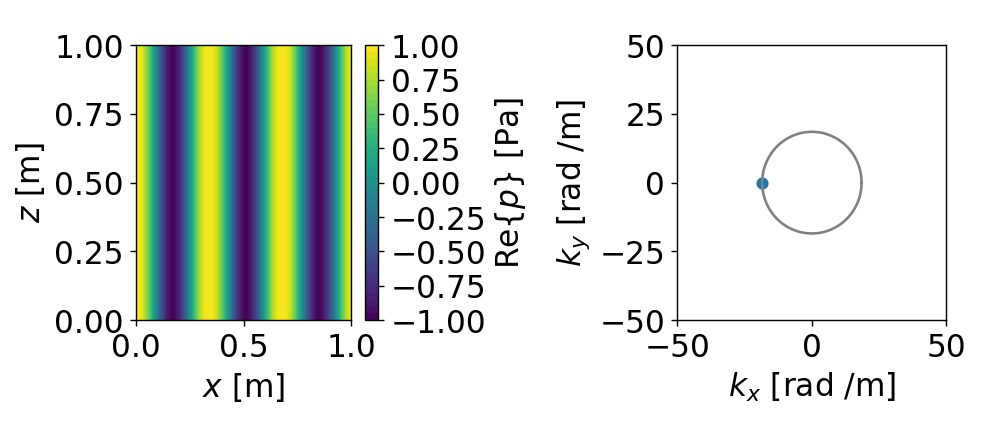

In [5]:
# Campo sonoro
A = 1
pres_p = p_pw_xz(amp = A, kvec = kvec, x_grid = x_grid, z_grid = z_grid)

# plot
plot_cmap_pres(x_grid, z_grid, np.real(pres_p), k0, kvec)

# O vetor intensidade

O vetor intensidade sonora (valor médio da intensidade) é

\begin{equation}
\vec{I} = I_x \hat{x} + I_y \hat{y} + I_z \hat{z}
\end{equation}

com cada componente dada por

\begin{equation}
I_{\cdot} = \frac{1}{2}\mathcal{R}e\left\{p u_{\cdot}^{*}\right\}
\end{equation}

Assim, temos que:

\begin{equation}
I_{x} = \frac{1}{2}\mathcal{R}e\left\{A(\omega) \text{e}^{-\text{j}(\textbf{k} \cdot \textbf{r})} \frac{1}{\rho_0 c_0}\frac{k_{x}}{k_0} A^{*}(\omega)\text{e}^{+\text{j}(\textbf{k} \cdot \textbf{r})} \right\}
\end{equation}

\begin{equation}
I_{x} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0} \frac{k_{x}}{k_0} \hat{x}
\end{equation}

\begin{equation}
I_{y} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0} \frac{k_{y}}{k_0} \hat{y}
\end{equation}

\begin{equation}
I_{z} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0} \frac{k_{z}}{k_0} \hat{z}
\end{equation}

e

\begin{equation}
\vec{I} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0 k_0} (k_{x} \hat{x} + k_{y} \hat{y} + k_{z} \hat{z})
\end{equation}

Claramente, a direção de propagação de uma **onda plana propagante** é

\begin{equation}
\textbf{k} = k_{x} \hat{x} + k_{y} \hat{y} + k_{z} \hat{z}
\end{equation}

Para o caso investigado:

In [6]:
I = (np.abs(A)**2/(2*rho0*c0*k0))*kvec

print("O vetor intensidade é: ({}, {}, {})".format(I[0], I[1], I[2]))

O vetor intensidade é: (-0.001215362177929023, -0.0, 0.0)


# Ondas planas evanescentes

Acontecem para 

\begin{equation}
k_{z} = -\text{j} \sqrt{(k_{x}^{2}+k_{y}^{2})-k_0^2} = -\text{j}k_{z}^{'} ,\ \ \ \ \mbox{se} \ \ \ \  k_{x}^{2}+k_{y}^{2} > k_0^2
\end{equation}

As coordenadas de $\textbf{k}$ caem **(fora do circulo de radiação)**.

Vamos investigar algumas ondas planas evanescentes. Neste caso

\begin{equation}
\tilde{p} = A(\omega) \text{e}^{-\text{j} (-\text{j}k_{z}^{'}z)} \text{e}^{-\text{j}(k_x x + k_y y)},
\end{equation}

\begin{equation}
\tilde{p} = A(\omega) \text{e}^{-k_{z}^{'}z} \text{e}^{-\text{j}(k_x x + k_y y)}
\end{equation}

indicando decaimento da pressão sonora ao longo do eixo $z$.

In [7]:
# (variáveis independentes kx e ky)
kx = 2*k0
ky = 0.5*k0

# variável dependentes kz
kz = -1j * np.sqrt((kx**2 + ky**2) - k0**2 )

kvec = np.array([kx, ky, kz])
print("vetor número de onda: ({}, {}, {})".format(kvec[0], kvec[1], kvec[2]))
#kvec_e = np.array([kxe, kye, kze])

vetor número de onda: ((36.95991357164462+0j), (9.239978392911155+0j), -33.315215879820514j)


<IPython.core.display.Javascript object>


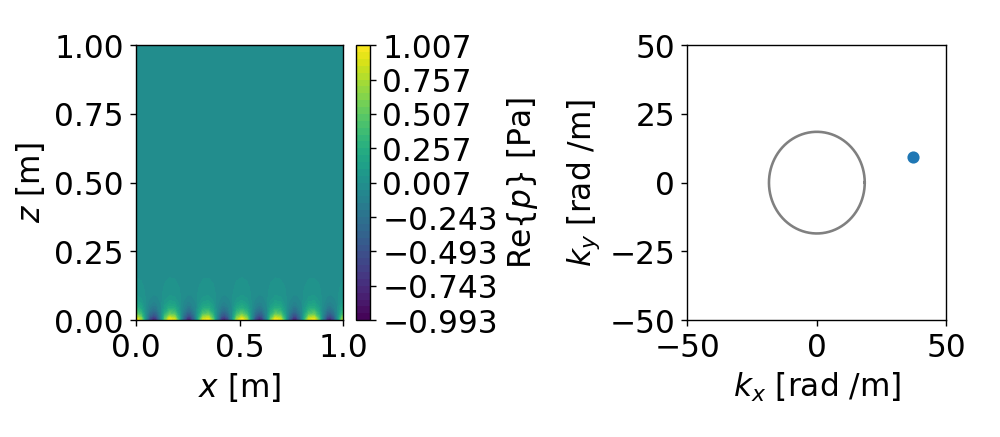

In [27]:
pres_e = p_pw_xz(amp = A, kvec = kvec, x_grid = x_grid, z_grid = z_grid)

# plot
plot_cmap_pres(x_grid, z_grid, np.real(pres_e), k0, kvec)

# O vetor intensidade

Neste caso, teremos o seguinte:

\begin{equation}
u_{x} = \frac{1}{2} \frac{1}{\rho_0 c_0}\frac{k_{x}}{k_0} A(\omega)\text{e}^{-\text{j}(k_x x + k_y y - \text{j} k_{z}^{'} z)}
\end{equation}

\begin{equation}
u_{x} = \frac{1}{2} \frac{1}{\rho_0 c_0}\frac{k_{x}}{k_0} A(\omega)\ \text{e}^{ - k_{z}^{'} z} \ \text{e}^{-\text{j}(k_x x + k_y y)},
\end{equation}
que possui um termo de decaimento em $z$ e apenas coordenadas $\hat{x}$ e $\hat{y}$. Assim, o vetor intensidade é:

\begin{equation}
\vec{I} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0 k_0} \text{e}^{-2 k_{z}^{'} z} (k_{x} \hat{x} + k_{y} \hat{y}),
\end{equation}

Claramente, a ela decai na direção $\hat{z}$. A direção de propagação de uma **onda plana evanescente** é

\begin{equation}
\textbf{k} = k_{x} \hat{x} + k_{y} \hat{y}
\end{equation}

Portanto, uma onda evanescente tem um vetor intensidade viajando numa **direção paralela** aos eixos $\hat{x}$ e $\hat{y}$.

Para o caso investigado:

In [8]:
I = (np.abs(A)**2/(2*rho0*c0*k0))*kvec

print("O vetor intensidade é: ({}, {})".format(I[0], I[1]))

O vetor intensidade é: ((0.002430724355858046+0j), (0.0006076810889645115+0j))


# Pistão quadrado num baffle infinito (Toy problem)

Este pode ser visto como um caso particular de um problema mais genérico de uma distribuição de fontes no plano $z_s = 0$. Tal problema é modelado pela integral de Rayleigh, a saber:

\begin{equation}
p(\textbf{r}) = \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi} \iint \limits_{-\infty}^{+\infty} v(x^{'}, y^{'}, z_s)\frac{\text{e}^{-\text{j}k_0|\textbf{r}-\textbf{r}^{'}|}}{|\textbf{r}-\textbf{r}^{'}|}\text{d}x^{'}\text{d}y^{'}
\end{equation}
em que:

- $\textbf{r} = (x_m, y_m, z_m)$ é o ponto em que mensuramos a pressão sonora
- $\textbf{r}^{'} = (x^{'}, y^{'}, z_s)$ é um ponto na superfície da fonte sonora (usualmente $z_s = 0$ é o chamado **source plane**)
- $v(x^{'}, y^{'}, z_s)$ é a distribuição de velocidades no plano das fontes, $z_s$.

Podemos escrever a equação da seguinte forma:

\begin{equation}
p(x_m, y_m, z_m) = \iint \limits_{-\infty}^{+\infty} v(x^{'}, y^{'}, z_s) \ \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi}\frac{\text{e}^{-\text{j}k_0\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}}}{\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}}\text{d}x^{'}\text{d}y^{'}
\end{equation}

e, então, notar que

\begin{equation}
p(x_m, y_m, z_m) = v(x^{'}, y^{'},z_s) \ ** \ g(x_m-x^{'}, y_m-y^{'}, z_m-z_s)
\end{equation}
em que a equação imediatamente acima é uma dupla convolução entre a distribuição de fontes no plano $z_s$ e a função de green

\begin{equation}
g(x_m-x^{'}, y_m-y^{'}, z_m-z_s) = \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi}\frac{\text{e}^{-\text{j}k_0\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}}}{\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}},
\end{equation}
que mapeia a radiação de cada fonte (**monopolo**) para o ponto de medição.

Se tomarmos a transformada espacial de Fourier dos dois lados da equação anterior, teremos

\begin{equation}
P(k_x, k_y, z_m) = V(k_x, k_y, z_s)  \ G(k_x, k_y)
\end{equation}
em que:

- $P(k_x, k_y, z_m)$ é o expectro de número de onda que conseguimos medir com um arranjo no plano $z_m$ (**measurement plane**),
- $V(k_x, k_y, z_s)$ é o expectro de número de onda que desejamos estimar no plano $z_s$ (**source plane**),
- $G(k_x, k_y)$ é conhecido analiticamente (Integral de Weyl), de forma que:

\begin{equation}
G(k_x, k_y) = \rho_0 c_0 k_0 \ \text{e}^{-\text{j}(k_x x + k_yy)} \ \frac{ \text{e}^{-\text{j}k_z (z_m-z_s)}}{k_z}
\end{equation}
com $\text{e}^{-\text{j} k_z (z_m - z_s)}$ representando a mudança de fase sofrida na translação da onda plana do plano $z_s$ (**source plane**) para o plano $z_m$ (**measurement plane**). 

Assim, ao medir  $P(k_x, k_y, z_m)$ podemos **deconvoluir** e estimar $V(k_x, k_y, z_s)$.

Vamos investigar um caso particular de um pistão quadrado e finito, vibrando com velocidade $v(x^{'}, y^{'}, 0) = 1$, em baffle rígido e infinito. Neste caso

\begin{equation}
p(\textbf{r}) = \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi} \int_{-L/2}^{+L/2} \int_{-L/2}^{+L/2} v(x^{'}, y^{'}, z_s)\frac{\text{e}^{-\text{j}k_0|\textbf{r}-\textbf{r}^{'}|}}{|\textbf{r}-\textbf{r}^{'}|}\text{d}x^{'}\text{d}y^{'}
\end{equation}

e podemos calcular a pressão sonora em qualquer ponto acima do pistão de maneira exata com integração numérica. Vamos fazer isso para

- um arranjo (usado para fazer a holografia)
- alguns pontos na vertical, usados para referência e comparar com a reconstrução holográfica
- uma esfera, para calcular a direcionalidade

**OBS:** As computações com integração numérica levam tempo. Pra acelerar as coisas na aula, eu pré-computei e salvei num objeto pkl. Você pode fazer outras computações se desejar.

In [9]:
# air and controls
air = AirProperties(temperature = 20)
controls = AlgControls(c0 = c0, freq_vec = [800, 1000, 2000])

# piston size
L = 0.5

# Dados medidos pelo arranjo (p/ Holografia)

In [40]:
# array to measure near the piston
array = Receiver()
array.planar_array(x_len=0.6, y_len=0.6, n_x = 10, n_y = 10, zr = 0.02)

In [94]:
# Sound field on array (used to do the holography)
field_array = PistonOnBaffle(air=air, controls=controls, receivers=array)
field_array.p_rigid_squared(Lx = L, Ly = L)
field_array.save('pob_arraycase')

Calculating Field...: 100%|██████████| 300/300 [01:17<00:00,  3.85it/s]


<IPython.core.display.Javascript object>


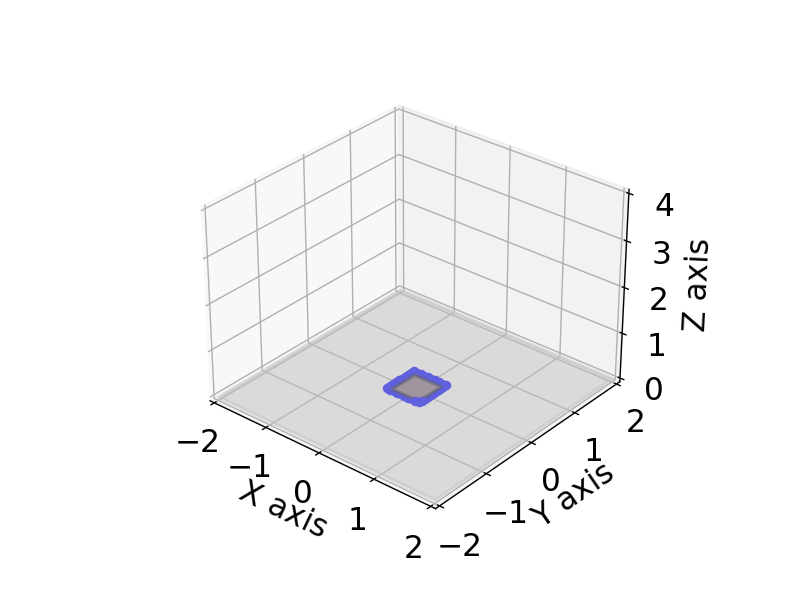

In [10]:
# Loading pre-computed
field_array = PistonOnBaffle()
field_array.load('pob_arraycase')
field_array.add_noise(snr = 60)
field_array.plot_scene(vsam_size = 4)

In [12]:
field_array.controls.freq

array([ 800, 1000, 2000])

# Dados medidos próximo ao pistão (p/ reconstrução - ref)

In [40]:
# reconstruction array to measure near holography array
recon_array = Receiver()
recon_array.planar_xz(x_len = 0.7, n_x = 140, z0 = 0.001 , z_len = 0.025, n_z = 5, yr = 0.0)

field_recon_array = PistonOnBaffle(air=air, controls=controls, receivers=recon_array)
field_recon_array.p_rigid_squared(Lx = L, Ly = L)
field_recon_array.save('pob_reconarraycase')

Calculating Field...: 100%|██████████| 2100/2100 [18:58<00:00,  1.84it/s] 


In [39]:
0.7/0.005

140.0

# Transformada espacial de Fourier (Criando a lógica da inversão)

Não vamos fazer inversão nesta aula, mas podemos nos adiantar e construir uma lógica.

Vamos criar um grid ($k_x$ vs. $k_y$) de ondas planas. Note:

- O círculo de radiação é plotado em cinza e tem raio $k_0$ 
- Há pontos neste grid **dentro** do circulo de radiação (ondas planas **propagantes**)
- Há pontos neste grid **fora** o do circulo de radiação (ondas planas **evanescentes**)

In [14]:
# Frequência
f = 2000
c0 = 340
rho0 = 1.21

# Piston size
L= 0.5

# Magnitude do numero de onda
k0 = 2*np.pi*f/c0

In [15]:
# Criar um grid kx vs. ky
kxlims = 60
kx = np.linspace(start = -kxlims, stop = kxlims, num = 60)
ky = np.linspace(start = -kxlims, stop = kxlims, num = 60)
kx_grid, ky_grid = np.meshgrid(kx, ky)

<IPython.core.display.Javascript object>


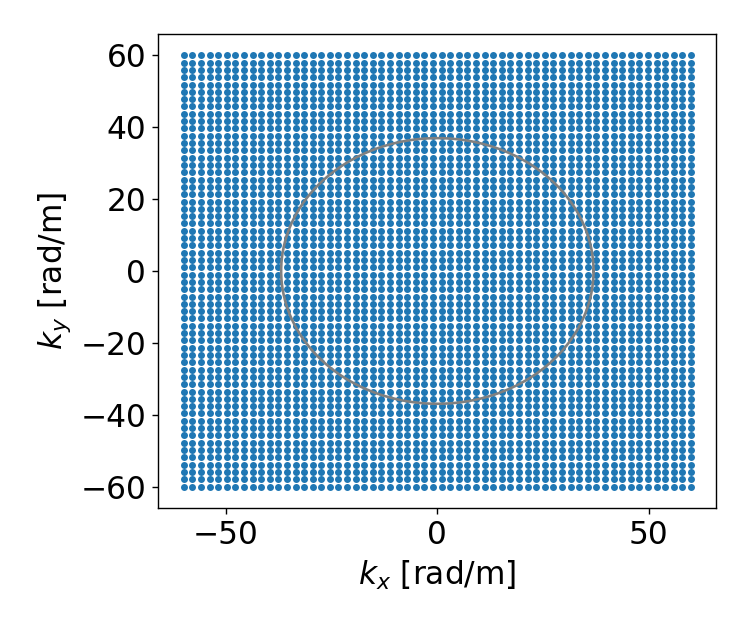

In [16]:
fig = plt.figure(figsize = (6,5))
plt.scatter(kx_grid.flatten(), ky_grid.flatten(), marker = '.')
plt.plot(k0*np.cos(np.arange(0, 2*np.pi+0.01, 0.01)),
    k0*np.sin(np.arange(0, 2*np.pi+0.01, 0.01)), 'Gray')
plt.xlabel(r'$k_x$ [rad/m]')
plt.ylabel(r'$k_y$ [rad/m]')
plt.tight_layout();

# Pensando sobre $k_z$

Vamos formar o vetor $k_z$

\begin{equation}
k_z = \begin{cases} \sqrt{k_0^2-(k_{x}^{2}+k_{y}^{2})}, & \mbox{se  }  k_{x}^{2}+k_{y}^{2} \leq k_0^2, & \mbox{**(dentro da circunferência)**} \\ -\text{j} \sqrt{(k_{x}^{2}+k_{y}^{2})-k_0^2}, & \mbox{se }  k_{x}^{2}+k_{y}^{2} > k_0^2, & \mbox{**(fora da circunferência)**} \end{cases},
\end{equation}

e fazer um plot simplificado

<IPython.core.display.Javascript object>


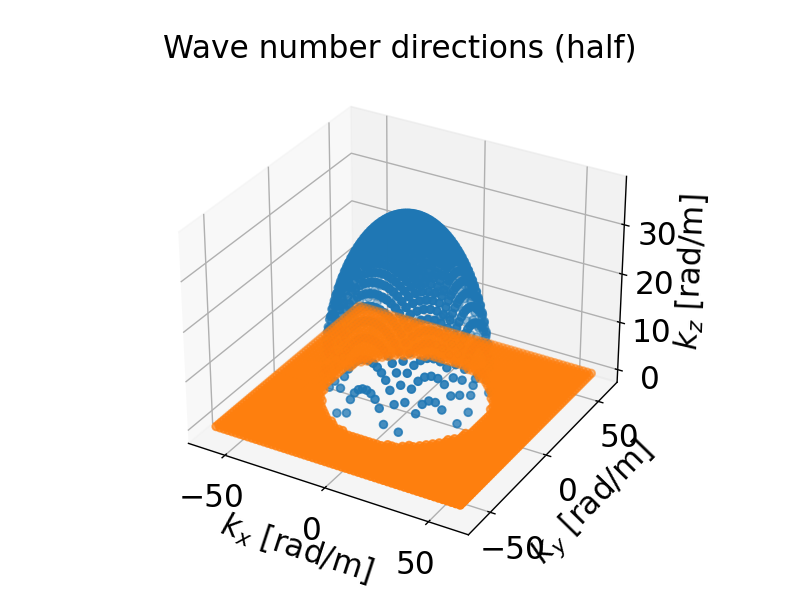

In [17]:
form_kz(k0, kx_grid.flatten(), ky_grid.flatten(), plot=True);

# Vamos computar a solução analítica


Para o caso do pistão quadrado com velocidade constante, podemos escrever:

\begin{equation}
    v(x^{'}, y^{'}, 0) = \begin{cases}
      1 \ \ \ \ \text{para} \ \ \ \ \frac{-L}{2} \leq x^{'} \leq \frac{L}{2} \ \ \ \ \& \ \ \ \ \frac{-L}{2} \leq y^{'} \leq \frac{-L}{2} \\
      0 \ \ \ \  \text{caso contrário}
    \end{cases}\
\end{equation}

com Transformada Espacial de Fourier

\begin{equation}
    V(k_x, k_y, 0) = L^2 \text{sinc}\left(k_x \frac{L}{2}\right) \ \text{sinc}\left(k_y \frac{L}{2}\right)
\end{equation}

Vamos plotar este espectro. Lembre-se $k_z$ depende de $k_x$ e $k_y$

In [34]:
V_kx_ky = (L**2)*np.sinc(kx_grid * L/(2*np.pi))*np.sinc(ky_grid * L/(2*np.pi))

dinrange = 40
color_par = 20*np.log10(np.abs(V_kx_ky)/np.amax(np.abs(V_kx_ky)))
id_outofrange = np.where(color_par < -dinrange)
color_par[id_outofrange] = -dinrange
color_range = np.linspace(-dinrange, 0, 21)

<IPython.core.display.Javascript object>


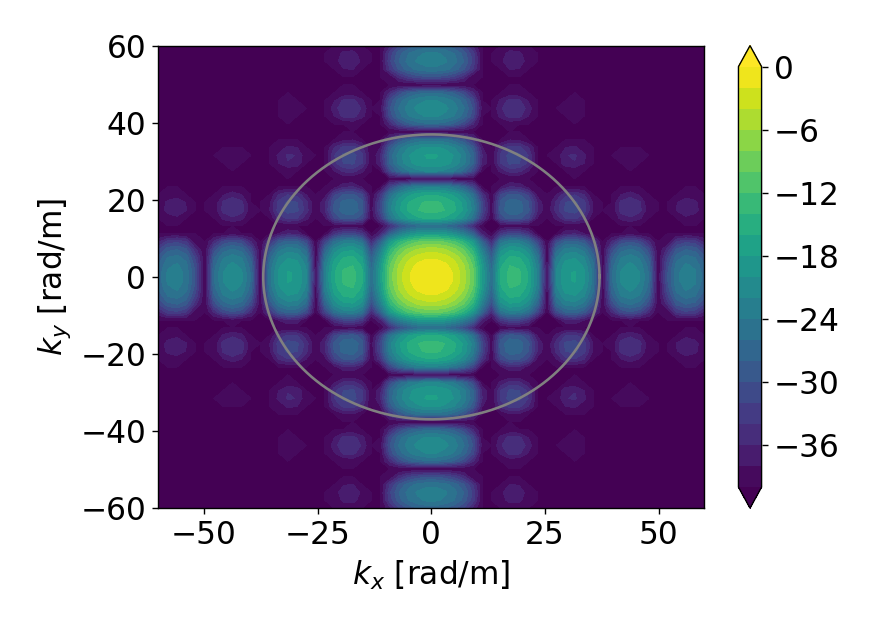

In [35]:
fig = plt.figure(figsize=(7, 5))
plt.plot(k0*np.cos(np.arange(0, 2*np.pi+0.01, 0.01)), k0*np.sin(np.arange(0, 2*np.pi+0.01, 0.01)), 'Gray')
p = plt.contourf(kx_grid, ky_grid, color_par, color_range, extend='both', cmap = 'viridis')
fig.colorbar(p)
plt.xlabel(r'$k_x$ [rad/m]')
plt.ylabel(r'$k_y$ [rad/m]')
plt.tight_layout();

# Direcionalidade (Far Field)

Podemos pensar na direcionalidade como a pressão sonora distribuída numa hemisfera no campo distante: $\textbf{r}_m \rightarrow \infty$. Neste caso a direcionalidade é função apenas dos ângulos de elevação, $\theta$, e azimute, $\phi$

\begin{equation}
    D(\theta, \phi) = \frac{-\text{j} \rho_0 c_0 k_0}{2 \pi} \text{sinc}\left(k_0 \frac{L}{2}\text{sin}(\theta)\text{cos}(\theta)\right) \ \text{sinc}\left(k_0 \frac{L}{2}\text{sin}(\theta)\text{sin}(\theta)\right)
\end{equation}

**OBS:** As componentes do espectro do número de onda, associadas as ondas **propagantes** (dentro do círculo de radiação) carregam essa informação.

In [48]:
# array to measure near the piston
hemisph_array = Receiver()
hemisph_array.hemispherical_array(radius = 20, n_rec_target = 642)
r, theta, phi = cart2sph(hemisph_array.coord[:,0], hemisph_array.coord[:,1], hemisph_array.coord[:,2])

In [38]:
field_sph = PistonOnBaffle(air=air, controls=controls, receivers=hemisph_array)
field_sph.p_rigid_squared(Lx = L, Ly = L)
field_sph.save('pob_sphericalcase')

NameError: name 'air' is not defined

<IPython.core.display.Javascript object>


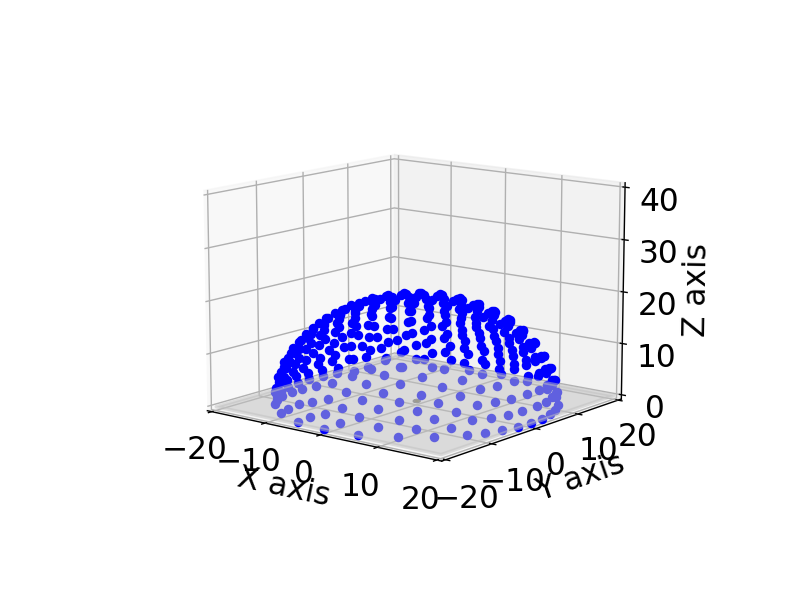

In [41]:
# Loading pre-computed
field_sph = PistonOnBaffle()
field_sph.load('pob_sphericalcase')
field_sph.plot_scene(vsam_size = 40)

In [52]:
fig, trace = plot_3d_polar(field_sph.receivers.coord, pk.conectivities, field_sph.pres_s[:,2], dinrange = 50,
                  color_method = 'dB', radius_method = 'dB',
                  color_code = 'jet', view = 'iso_z', eye = None,
                  renderer = 'notebook', remove_axis = False)
fig.show()

# Cenas do próximo cap.

In [20]:
pk = DecompositionEv2(p_mtx = field_array.pres_s, controls = field_array.controls, 
                     receivers = field_array.receivers, regu_par = 'l-curve')
pk.prop_dir(n_waves = 642, plot = False)
pk.pk_tikhonov_ev_ig(f_ref=1, f_inc=0, factor=1, zref = 0.0, plot_l=False, method = 'Tikhonov')

You choose L-curve to find optimal regularization parameter


Calculating Tikhonov inversion (with evanescent waves and irregular grid)...:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Cliente\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Calculating Tikhonov inversion (with evanescent waves and irregular grid)...: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


<IPython.core.display.Javascript object>


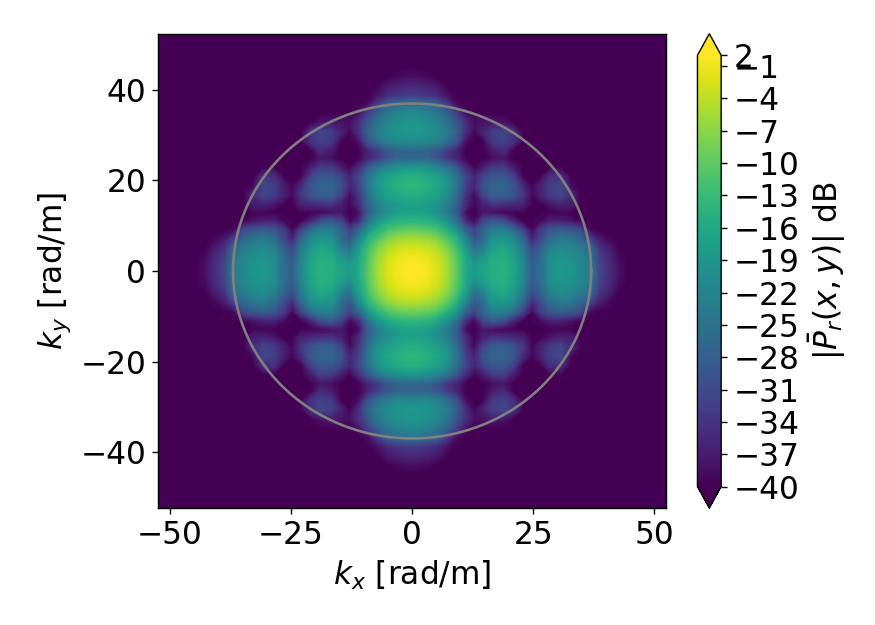

In [21]:
pk.plot_pkmap_v2(freq = 2000, db = True, plot_incident = False, dinrange = 40, color_code='viridis', figsize = (7,5))

In [22]:
fig, trace = pk.plot_directivity(freq = 2000, dinrange = 40, color_code = 'jet', true_directivity = True)
fig.show()

In [23]:
pk.lambd_value_vec

array([0.58027283, 0.62954641, 1.33989685])

In [33]:
print(pk.pdir.shape)
print(pk.conectivities.shape)

(337, 3)
(624, 3)


In [30]:
pk = DecompositionEv(p_mtx=field_array.pres_s, controls=field_array.controls, receivers = field_array.receivers)
pk.create_kx_ky(n_kx = 50, n_ky = 50, plot=False, freq = 1000)
#pk.pk_tikhonov_ev(method = 'Tikhonov')
pk.pk_tikhonov_ev(method='Tikhonov', f_ref = 1.0, f_inc = 0, factor = 1.0, z0 = 0, plot_l = False)

You choose L-curve to find optimal regularization parameter


Calculating Tikhonov inversion (with evanescent waves)...: 100%|██████████| 3/3 [00:00<00:00, 12.69it/s]


<IPython.core.display.Javascript object>


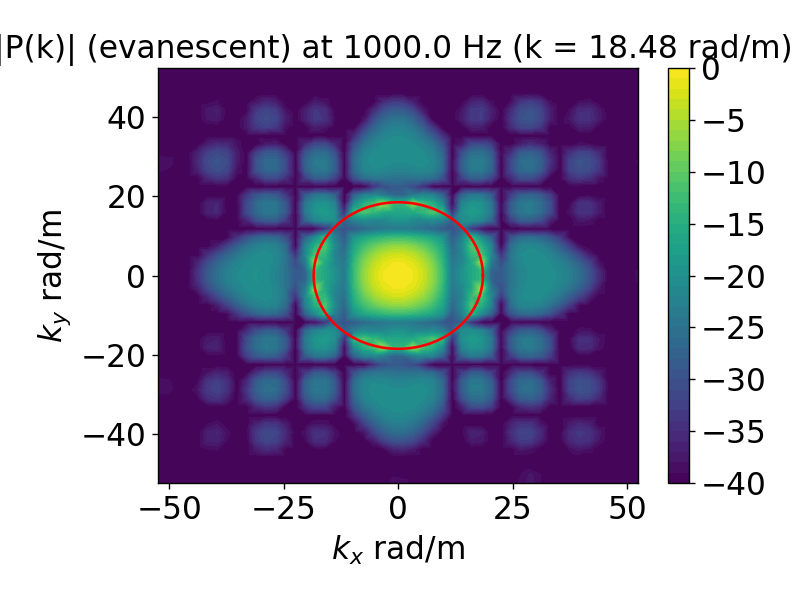

In [32]:
pk.plot_pk_evmap(freq = 1000, db = True, dinrange = 40)

In [33]:
pk.lambd_value_vec

array([0.01525807, 0.01494702, 0.02505966])

<IPython.core.display.Javascript object>


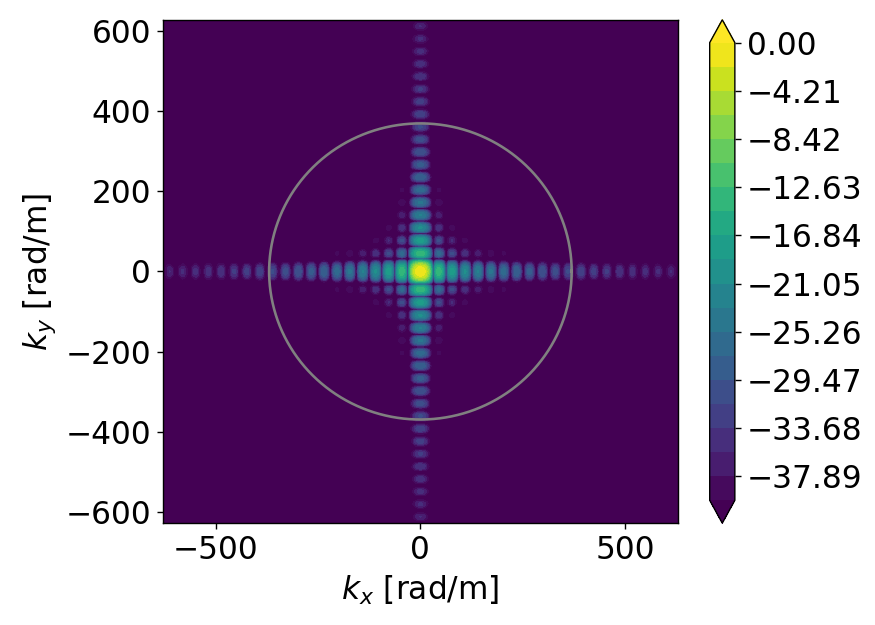

In [64]:
# Frequência
f = 20000
c0 = 340
rho0 = 1.21

# Piston size
L= 0.2

# Magnitude do numero de onda
k0 = 2*np.pi*f/c0

# Criar um grid kx vs. ky
kxlims = np.pi/0.005
kx = np.linspace(start = -kxlims, stop = kxlims, num = int(kxlims))
ky = np.linspace(start = -kxlims, stop = kxlims, num = int(kxlims))
kx_grid, ky_grid = np.meshgrid(kx, ky)

V_kx_ky = (L**2)*np.sinc(kx_grid * L/(2*np.pi))*np.sinc(ky_grid * L/(2*np.pi))

dinrange = 40
color_par = 20*np.log10(np.abs(V_kx_ky)/np.amax(np.abs(V_kx_ky)))
id_outofrange = np.where(color_par < -dinrange)
color_par[id_outofrange] = -dinrange
color_range = np.linspace(-dinrange, 0, 20)

fig = plt.figure(figsize=(7, 5))
plt.plot(k0*np.cos(np.arange(0, 2*np.pi+0.01, 0.01)), k0*np.sin(np.arange(0, 2*np.pi+0.01, 0.01)), 'Gray')
p = plt.contourf(kx_grid, ky_grid, color_par, color_range, extend='both', cmap = 'viridis')
fig.colorbar(p)
plt.xlabel(r'$k_x$ [rad/m]')
plt.ylabel(r'$k_y$ [rad/m]')
plt.tight_layout();